In [265]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd


In [144]:
def my_svd(data, tname='time', uname='u', vname='v', spacename='z', tresh=0.90,plot=False):
    u_mean=data[uname].mean(dim=tname)
    v_mean=data[uname].mean(dim=tname)
    uu=(data[uname]-u_mean).where(data.land_binary_mask==0).dropna(dim=spacename).data
    vv=(data[vname]-v_mean).where(data.land_binary_mask==0).dropna(dim=spacename).data
    
    C=np.dot(uu.T, vv)
    U,L,Vh = np.linalg.svd(C)
    
    V=Vh.T
    SCF=L/np.sum(L)
    indx=int(np.argwhere(np.cumsum(SCF)>tresh)[0])+1
    

    U=U[:,0:indx]
    V=V[:,0:indx]
    L=L[0:indx]
    SCF=SCF[0:indx]
    A=uu@U
    B=vv@V
    
    re_U=A@U.T
    re_V=B@V.T
    if plot:
        plt.plot(SCF)
        plt.xlim(0,10)
        plt.plot(np.cumsum(SCF))
    print(A.shape)
    out=data.copy()
    out['u_pcs']=((tname,'mode'),A)
    out['v_pcs']=((tname,'mode'),B)
    out['u_eofs']=((u_mean.dims + ('mode',)),U)
    out['v_eofs']=((v_mean.dims + ('mode',)),V)
    out['eigen']=(('mode'),L)
    out['SCF']=(('mode'),SCF)

    return out

def my_svd_randomized(data, tname='time', uname='u', vname='v', spacename='z', N=20,plot=False,random_state=10):
    data=data.where(data.land_binary_mask==0).dropna(dim='z')
    u_mean=data[uname].mean(dim=tname)
    v_mean=data[vname].mean(dim=tname)
    uu=(data[uname]-u_mean).data # Need a warning here. Will alter the calculations. 
    vv=(data[vname]-v_mean).data
    
    C=np.dot(uu.T, vv)
    U,L,Vh = randomized_svd(C,N,random_state=random_state)
    
    V=Vh.T

    A=uu@U
    B=vv@V
    
    re_U=A@U.T
    re_V=B@V.T
    if plot:
        plt.plot(L)
        
    out=data.copy()
    out['u_mean']=u_mean
    out['v_mean']=v_mean
    out['u_pcs']=((tname,'mode'),A)
    out['v_pcs']=((tname,'mode'),B)
    out['u_eofs']=((u_mean.dims + ('mode',)),U)
    out['v_eofs']=((v_mean.dims + ('mode',)),V)
    out['eigen']=(('mode'),L)
    out['speed']=np.sqrt(out.u**2+out.v**2)
    angles=np.arctan2(out['v'],out['u'])
    out['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)

    return out

    def my_tide(data,tname='time', uname='u', vname='v', spacename='z')
    

In [3]:
def eofs_GA(inxarr, variables=['u','v'], neofs=10, time_name='time', npcs=5, treshold=None):
    tmp=inxarr[variables]
    tmp=tmp.to_stacked_array('z_loc',sample_dims=[time_name]).fillna(0)
    solver = Eof(tmp)
 
    out=solver.eofs(neofs=neofs).to_unstacked_dataset('z_loc').unstack()
    #xr.Dataset()
    out['X']=inxarr['X']
    out['Y']=inxarr['Y']
    out['time']=inxarr['time']
    out['eigenvals']=solver.eigenvalues()
    out['land_binary_mask']=inxarr['land_binary_mask']
    #if treshold < lmbda.mode.max(): 
    #    np.searchsorted(lmbda.cumsum()/lmbda.sum(),[0.9,],side='right')[0]
    # eofs=solver.eofs(neofs=5).to_unstacked_dataset('z_loc').unstack()
    # out['eofs_u']=eofs['u']
    # out['eofs_v']=eofs['v']
    out['speed']=np.sqrt(out.u**2+out.v**2)
    angles=np.arctan2(out['v'],out['u'])
    out['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)
    out['pcs']=solver.pcs(npcs=npcs)

    return out

    


In [80]:
##NOT working
def plot_eofs(res,name='',save_dir='',save=False):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.7)
    fig.suptitle("Eofs" + name, fontsize=18, y=0.95)
    axes=axs.ravel()
    res.eigen.isel(mode=[0,1,2,3]).plot.line(x='time',ax=axes[0])
    
    for mode in np.arange(4):
        res.isel(mode=mode).where(res.land_binary_mask==0).plot.quiver(x='X',y='Y' ,u='u', v='v',hue='u',ax=axes[mode+2])

    if save:
        plt.savefig(save_dir+name+'.jpg')

In [120]:
data=xr.open_dataset('Data/byfjordenSubset.nc')

In [6]:
data

<xarray.Dataset>
Dimensions:           (time: 1501, depth: 30, Y: 400, X: 201)
Coordinates:
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * depth             (depth) float32 1.0 3.0 5.0 10.0 ... 550.0 600.0 650.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, depth, Y, X) float32 ...
    v                 (time, depth, Y, X) float32 ...
    h                 (Y, X) float32 ...
    projection_stere  float32 ...
    land_binary_mask  (Y, X) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [7]:
# Select only May and surface
May=data.isel(time=data.time.dt.month.isin(4),depth=0)

In [8]:
May.isel(time=256).time

<xarray.DataArray 'time' ()>
array('2010-04-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    depth    float32 1.0
    time     datetime64[ns] 2010-04-20
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

In [121]:
May_stacked=May.stack(z=('Y','X'))

In [10]:

May_stacked['u_mean']=May_stacked.u.mean(dim='time')
May_stacked['v_mean']=May_stacked.v.mean(dim='time')

In [152]:
res=my_svd_randomized(May_stacked,N=100)

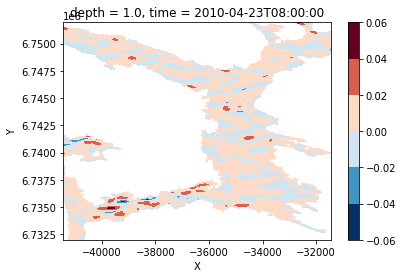

In [153]:
(res.u_pcs.dot(res.u_eofs.T)+res.u_mean-res.u).isel(time=301).unstack('z').plot.contourf()


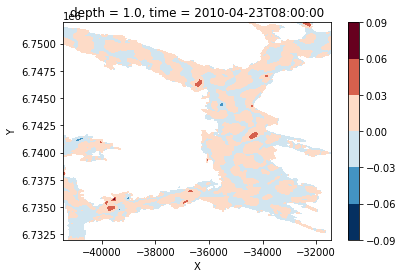

In [158]:

(res.v_pcs.dot(res.v_eofs)+res.v_mean-res.v).isel(time=301).unstack('z').plot.contourf()


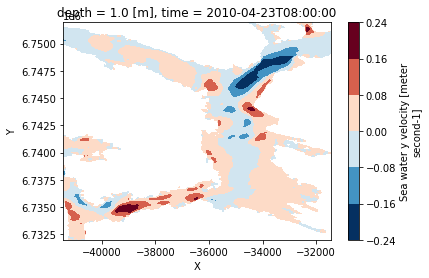

In [155]:
(res.v).isel(time=301).unstack('z').plot.contourf()

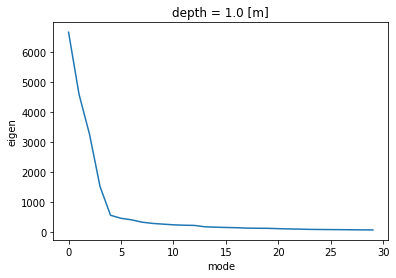

In [115]:
res.eigen.plot()

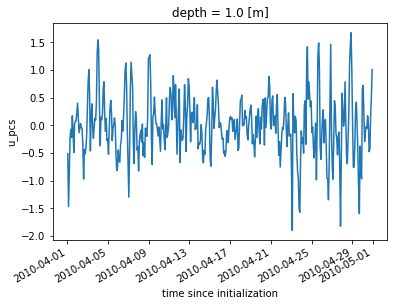

In [72]:
res.unstack('z').direction.isel(mode=19).plot()

In [215]:
May

<xarray.Dataset>
Dimensions:           (time: 405, Y: 400, X: 201)
Coordinates:
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-04-01T00:53:20 ... 2010-04-3...
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    v                 (time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 23.12 ... 0.0 0.0 0.0 0.0
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [216]:
ix=98
iy=84

tmpu=May.isel(X=ix,Y=iy)

tmpu.u.max()


<xarray.DataArray 'u' ()>
array(0.23049769, dtype=float32)
Coordinates:
    X        float32 -3.654e+04
    Y        float32 6.736e+06
    depth    float32 1.0

In [267]:
from datetime import datetime
datetime(time)

TypeError: only integer scalar arrays can be converted to a scalar index

In [261]:

time=date2num(tmpu.time.to_pandas())

coef = solve(time, (tmpu.u-tmpu.u.mean(dim='time')).data,(tmpu.v-tmpu.v.mean(dim='time')).data, lat=60.0)#, method='OLS',  Rayleigh_min=0.95,nodal=True)

tide = reconstruct(time, coef)

solve: matrix prep ... solution ... done.
prep/calcs ... done.


Text(0.5, 1.0, 'Residue')

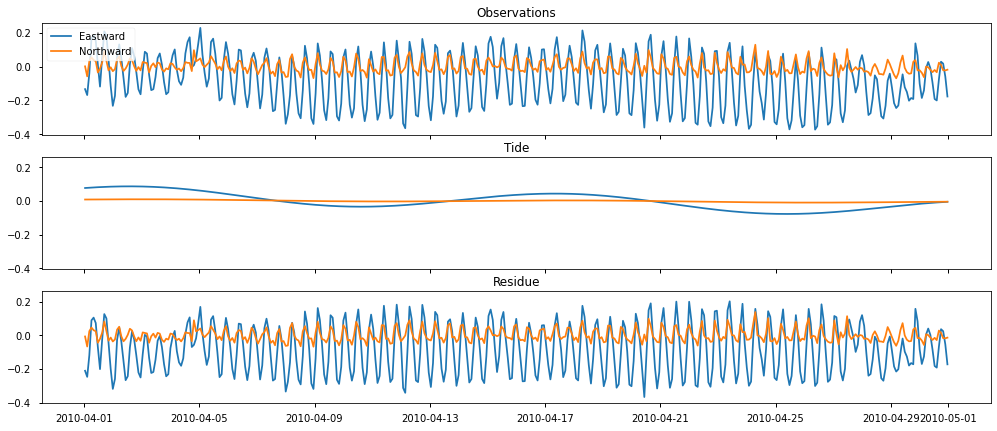

In [266]:
from matplotlib import style

style.use('seaborn-notebook')
t=num2date(time)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,  figsize=(17, 7))

ax0.plot(t, tmpu.u, label='Eastward')
ax0.plot(t, tmpu.v, label='Northward')
ax0.legend(numpoints=1, loc='upper left')
ax0.set_title('Observations')


ax1.plot(t, tide['u'] )
ax1.plot(t, tide['v'])
ax1.set_title('Tide')
#ax1.legend(numpoints=1, loc='upper left')

ax2.plot(t, tmpu.u-tide['u'])
ax2.plot(t, tmpu.v-tide['v'])
ax2.set_title('Residue')

In [172]:
type(coef)
from pickle import dump

dump(coef,open('test.pkl','wb'))

utide.utilities.Bunch

In [34]:
U,L,Vh = randomized_svd(C,20)

/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:370: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [36]:
np.shape(U)

(28375, 20)

In [173]:
from pickle import dump

dump(coef,open('test.pkl','wb'))

In [43]:
res=eofs_GA(May_stacked,neofs=None)
res['land_binary_mask']=May['land_binary_mask']
res

NotImplementedError: isna is not defined for MultiIndex

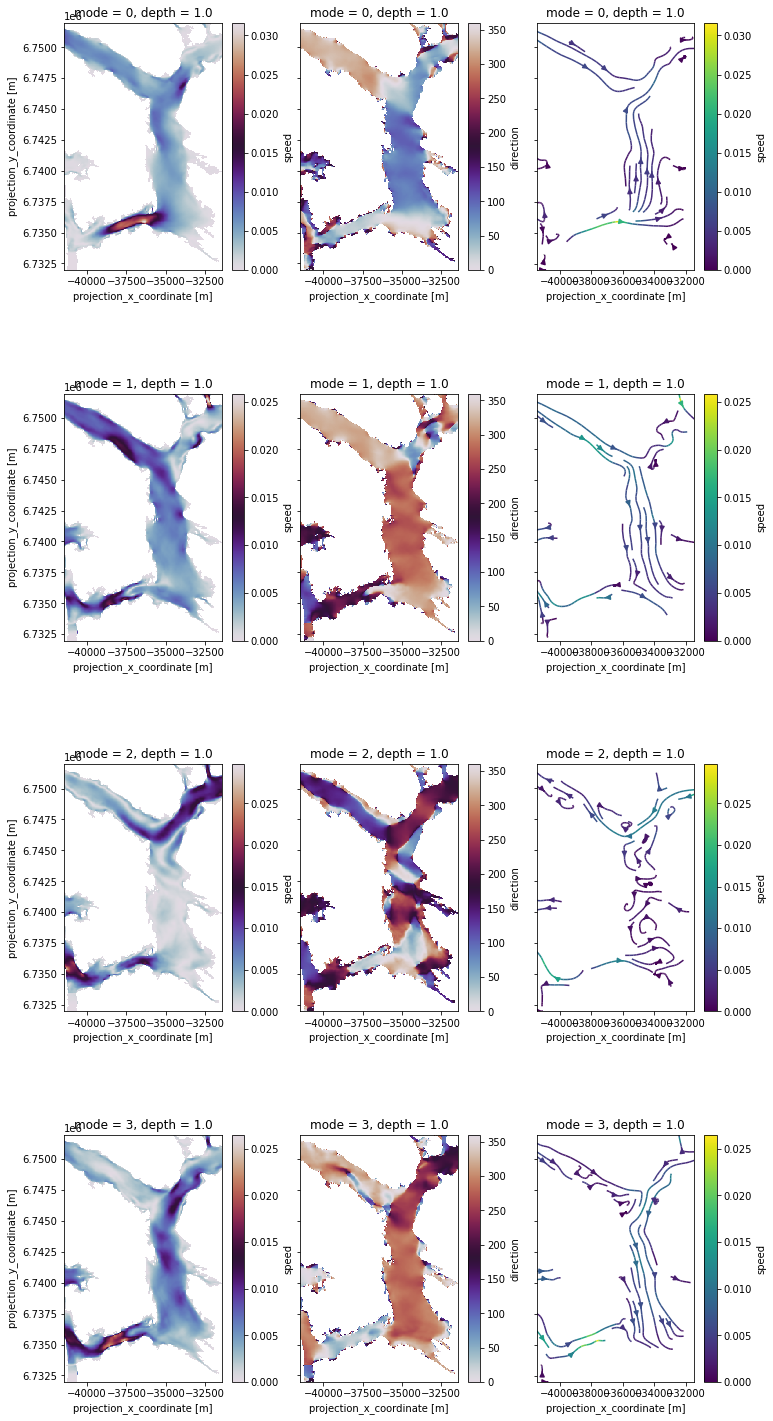

In [27]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 25))
plt.subplots_adjust(hspace=0.5)
axes=axs.ravel()
for mode in np.arange(4):
    res['speed'].where(res.land_binary_mask==0).isel(mode=mode).plot(ax=axes[3*mode],cmap='twilight')
    
    res['direction'].where(res.land_binary_mask==0).isel(mode=mode).plot(cmap='twilight',ax=axes[3*mode+1])
    res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v',hue='speed',ax=axes[3*mode+2])
    axs[mode][1].set_ylabel('')
    axs[mode][1].set_yticklabels('')
    axs[mode][2].set_ylabel('')
    axs[mode][2].set_yticklabels('')


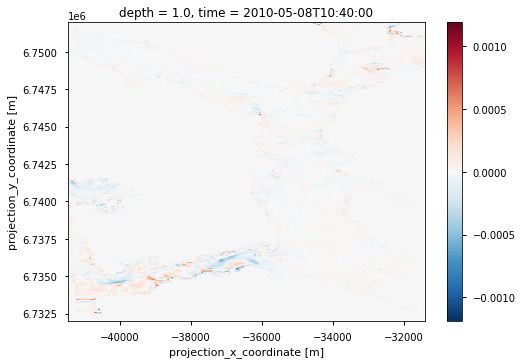

In [99]:
(May.isel(depth=0).u.differentiate(coord='X')+May.isel(depth=0).v.differentiate(coord='Y')).isel(time=100).plot()


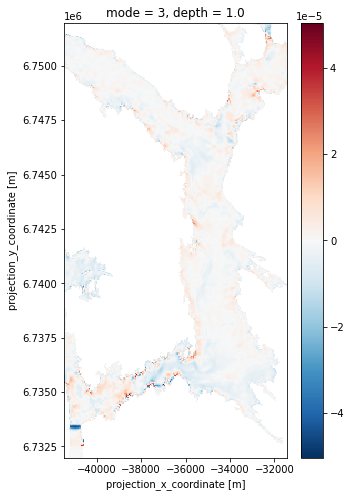

In [77]:
tmp=res.isel(mode=3)
(tmp.u.differentiate(coord='X')+tmp.v.differentiate(coord='Y')).where(res.land_binary_mask==0).plot(figsize=(5,8))


In [90]:
tmp[1]

<AxesSubplot:title={'center':'mode = 1, depth = 3.0'}, xlabel='projection_x_coordinate [m]', ylabel='projection_y_coordinate [m]'>

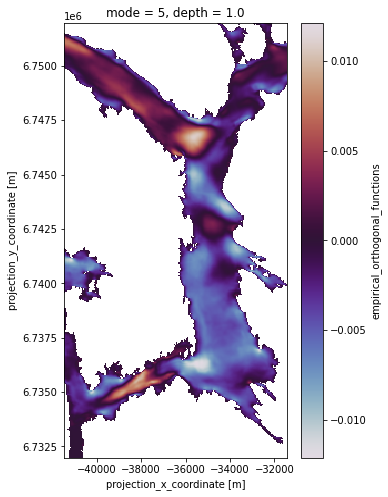

In [50]:
res['u'].where(res.land_binary_mask==0).isel(mode=5).plot(cmap='twilight',figsize=(5,8))

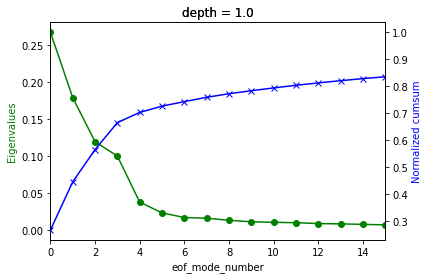

In [48]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
(res.eigenvals/res.eigenvals.sum()).plot(marker='o',color='g',ax=ax1)
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(color='b',marker='x',ax=ax2)

ax1.set_ylabel('Eigenvalues', color='g')
ax2.set_ylabel('Normalized cumsum', color='b')
plt.xlim(0,15)
plt.show()

(0.0, 5.0)

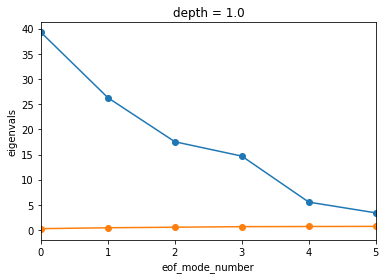

In [31]:
res.eigenvals.plot(marker='o')
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(marker='o')
plt.xlim(0,5)

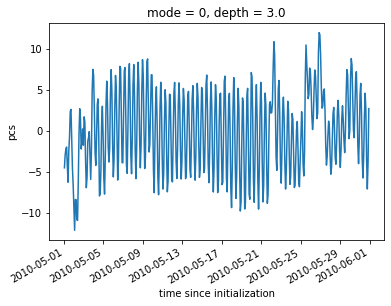

In [18]:
mode=0
res.pcs.isel(mode=mode).plot()

TypeError: __call__() takes 1 positional argument but 2 were given

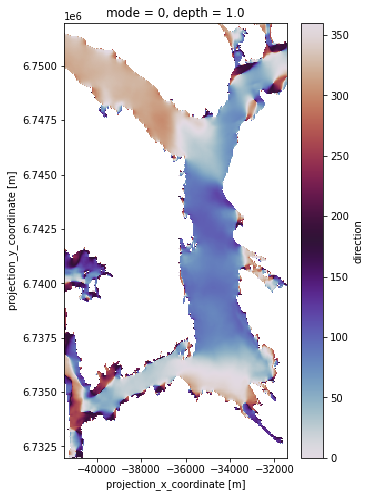

In [44]:
mode=10
res.direction.where(res.land_binary_mask==0).isel(mode=mode).plot()

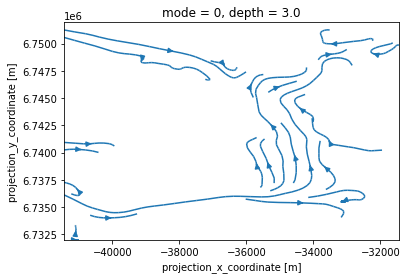

In [20]:
res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v')

In [113]:
help(xr.streamplot)

AttributeError: module 'xarray' has no attribute 'streamplot'

In [115]:
mode=4
tmp=(res.isel(mode=mode).pcs*res.isel(mode=mode).eigenvals)
tmp


<xarray.DataArray (time: 418)>
array([ 2.51191559e+01,  3.43576698e+01,  2.70350609e+01, -6.90878868e+00,
       -1.74213657e+01, -1.40487537e+01, -1.97940865e+01,  1.00656357e+01,
       -3.73587632e+00, -3.60380381e-01, -2.35856175e+00, -1.31972599e+00,
        4.25410423e+01,  7.04083099e+01,  4.00344772e+01, -5.73251247e+00,
       -1.60317554e+01, -1.57020779e+01, -1.47514153e+01, -1.57096205e+01,
       -1.64089279e+01, -1.43239803e+01, -1.14165907e+01, -2.42575722e+01,
       -5.26303368e+01,  3.73313560e+01,  5.59709435e+01,  9.72277546e+00,
       -1.40220869e+00, -5.83586979e+00, -5.90118408e+00, -3.76218820e+00,
        1.64434147e+01,  3.29918137e+01, -2.25301094e+01, -2.55837078e+01,
       -1.79004879e+01, -4.56511650e+01, -1.64342537e+01,  1.59816754e+00,
        7.08576250e+00,  3.00996566e+00,  6.32103741e-01,  1.37846696e+00,
        4.23830843e+00,  7.44553423e+00,  6.48577070e+00,  1.54397130e-01,
        4.01143951e+01, -1.38502455e+01,  1.22235184e+01, -7.12136936e+00,
       -7.84985685e+00, -1.17526674e+01, -1.27301912e+01, -1.05963640e+01,
       -1.13587770e+01, -8.01495266e+00, -3.98594689e+00, -1.42811193e+01,
       -2.55945563e+00, -1.58297396e+01,  2.40459251e+01,  8.79130363e+00,
        6.99451160e+00,  1.59862947e+00, -1.75135958e+00, -1.64975250e+00,
       -6.14190054e+00, -4.94580603e+00,  9.07736897e-01, -2.43802503e-01,
       -9.99710941e+00,  3.53043228e-01, -1.88284302e+01, -5.07494259e+00,
        2.14468288e+00,  2.38385424e-01, -7.97924566e+00, -4.85249901e+00,
...
        8.04285336e+00,  1.99379654e+01,  5.24168789e-01,  1.34703531e+01,
        4.16118956e+00,  1.04785514e+00, -2.66268682e+00, -2.62183208e+01,
       -5.69773674e+01, -4.00022507e+00,  2.31581593e+01,  1.88279190e+01,
        1.02514009e+01,  5.02461100e+00,  4.92792559e+00,  8.78254700e+00,
        1.20835199e+01,  1.27113161e+01,  1.04325953e+01,  6.80696106e+00,
        4.71250010e+00,  2.04208779e+00, -4.82542574e-01, -3.20232105e+00,
       -8.65886688e+00, -1.23804083e+01, -1.14530964e+01, -5.82128048e+00,
        6.08637631e-01,  2.64530611e+00,  2.94658560e-02, -3.36639309e+00,
       -5.08620930e+00, -5.91906118e+00, -1.98346651e+00, -6.93928838e-01,
       -3.81162310e+00, -1.08745260e+01, -1.19807243e+01, -1.07903414e+01,
       -4.38737202e+00,  8.65319633e+00, -2.78511524e+00, -2.76620502e+01,
        6.76414633e+00, -6.35042000e+00,  6.65179312e-01, -4.08597660e+00,
       -2.30468065e-02, -2.65089840e-01,  8.47981071e+00, -1.30473433e+01,
       -2.62149620e+01,  1.93823552e+00,  8.58087540e+00,  7.05244827e+00,
        6.99304962e+00,  6.60602951e+00, -5.28119326e-01,  1.10472040e+01,
        1.15295839e+01,  1.00335531e+01, -9.47922826e-01,  1.35852709e+01,
        2.80311370e+00, -5.82450247e+00,  2.05472541e+00,  1.98660803e+00,
       -5.46554041e+00, -8.06682873e+00,  1.21224232e+01,  1.92555122e+01,
        6.95254230e+00, -3.38021708e+00, -7.48701620e+00, -4.07501364e+00,
       -1.37264929e+01, -4.67563725e+00], dtype=float32)
Coordinates:
    mode     int64 4
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-31T22:13:20

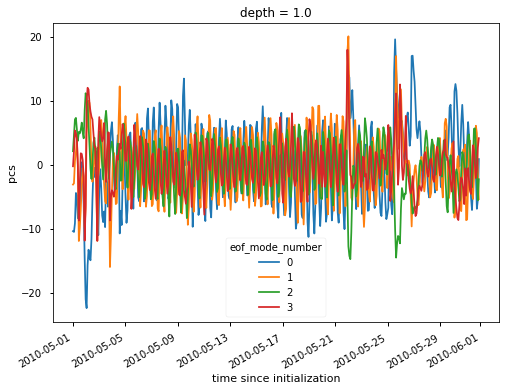

In [101]:
res.pcs.isel(mode=[0,1,2,3]).plot.line(x='time')

In [22]:
res

<xarray.Dataset>
Dimensions:           (mode: 10, Y: 400, X: 201, time: 1501)
Coordinates:
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 9
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    v                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eigenvals         (mode) float32 28.59 19.41 14.78 ... 1.008 0.9224 0.8579
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    speed             (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    direction         (mode, Y, X) float32 90.0 90.0 270.0 90.0 ... 0.0 0.0 0.0
    pcs               (time, mode) float32 -12.16 -2.491 -1.415 ... nan nan nan

In [45]:
date2num(res.time)

array([14730.03703704, 14730.11111111, 14730.18518519, 14730.25925926,
       14730.33333333, 14730.40740741, 14730.48148148, 14730.55555556,
       14730.62962963, 14730.7037037 , 14730.77777778, 14730.85185185,
       14730.92592593, 14731.        , 14731.07407407, 14731.14814815,
       14731.22222222, 14731.2962963 , 14731.37037037, 14731.44444444,
       14731.51851852, 14731.59259259, 14731.66666667, 14731.74074074,
       14731.81481481, 14731.88888889, 14731.96296296, 14732.03703704,
       14732.11111111, 14732.18518519, 14732.25925926, 14732.33333333,
       14732.40740741, 14732.48148148, 14732.55555556, 14732.62962963,
       14732.7037037 , 14732.77777778, 14732.85185185, 14732.92592593,
       14733.        , 14733.07407407, 14733.14814815, 14733.22222222,
       14733.2962963 , 14733.37037037, 14733.44444444, 14733.51851852,
       14733.59259259, 14733.66666667, 14733.74074074, 14733.81481481,
       14733.88888889, 14733.96296296, 14734.03703704, 14734.11111111,
      

In [46]:

coef = solve(date2num(res.time), y, lat=60.0, method='robust',Rayleigh_min=0.9)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

tide = reconstruct(date2num(res.time), coef)

coef.keys()

solve: matrix prep ... solution ... done.
prep/calcs ... done.


dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'rf', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])